# Fit series data and import fit results

Analyze high-cycle fatigue test data and fit a fatigue model using SciPy, using an approach suitable for automation
with either MI Data Flow or as a simple scheduled task (cron job).

## Connect to Granta MI

Specify a database and tables.

In [1]:
from GRANTA_MIScriptingToolkit import granta as mpy

s = mpy.Session('localhost', autologon=True)
database = s.get_db('MI Training')
statistics_table = database.get_table('Fatigue Statistical Data')
test_data_table = database.get_table('Fatigue Test Data')

## Search for records with statistical data

This script will perform a fatigue analysis on the first record whose *Statistical Analysis Status* is set to 'In Progress', but it can easily be generalised to operate on multiple statistical data records.

First, perform a criteria search to find the target record.

In [2]:
criterion_type = statistics_table.attributes['Material type'].search_criterion(contains='Aluminum alloys')
criterion_status = statistics_table.attributes['Statistical Analysis Status'].search_criterion(contains='In Progress')
records = statistics_table.search_for_records_where([criterion_type, criterion_status])
print('Found ' + str(len(records)) + ' corresponding HCF test results.')

r = records[0]
print('Analyzing fatigue data for "' + str(r.name) + '".')

Found 1 corresponding HCF test results.
Analyzing fatigue data for "7075 T6, R=0, T=430F".


## Get the source data for the record

Get the *R-Ratio* and *Test Temperature* values from the record, and fetch the corresponding test results. Then read the attribute values from the test result records into a `pandas` DataFrame for plotting and analysis.

In [3]:
import pandas as pd
import statistics

r_ratio = statistics.mean(r.attributes['Target R-Ratio Range'].value.values())
test_temperature = statistics.mean(r.attributes['Test Temperature Range'].value.values())
material_id = r.attributes['Alloy'].value + '-' + r.attributes['Condition'].value + '/' + r.attributes['Form'].value

criterion_r_ratio = test_data_table.attributes['Target r-ratio'].search_criterion(less_than=r_ratio,
                                                                                  greater_than=r_ratio)
criterion_temperature = test_data_table.attributes['Test temperature'].search_criterion(less_than=test_temperature,
                                                                                        greater_than=test_temperature)
criterion_material_id = test_data_table.attributes['Material ID'].search_criterion(contains=material_id)
records = test_data_table.search_for_records_where([criterion_r_ratio, criterion_temperature, criterion_material_id])

print("Found " + str(len(records)) + " corresponding HCF test results.")

t_results = ["Cyclic life", "Maximum stress", "Fatigue failure"]

rs_dict = {"ShortName" : [r.short_name for r in records]}
for attribute in t_results:
    if test_data_table.attributes[attribute].type == 'POIN':
        rs_dict[attribute] = [r.attributes[attribute].points[0] for r in records]
    if test_data_table.attributes[attribute].type == 'DISC':
        rs_dict[attribute] = [r.attributes[attribute].value[0] for r in records]

rs_df = pd.DataFrame(rs_dict)

Found 66 corresponding HCF test results.


## Fit the data

Fit the fatigue test data using the SciPy `curve_fit()` function, and create a new DataFrame for the fitted data and the lower bound.

In [4]:
from scipy.optimize import curve_fit
import numpy as np

def fatigue_func(x, A1, A2):
    return 10 **(A2 * np.log10(x) - A1)
                   
(A1, A2), pcov = curve_fit(fatigue_func, rs_df['Cyclic life'], rs_df['Maximum stress'],
                           bounds=([-500.0, -500.0], [500.0, 500.0]))

min_coefficient = 0.9
x = np.geomspace(rs_df['Cyclic life'].min(), rs_df['Cyclic life'].max(), rs_df['Cyclic life'].count())
fitted_series = 10 **(A2 * np.log10(x) - A1)

fitted_df = pd.DataFrame(index=x,
                         data=np.transpose([fitted_series, min_coefficient*fitted_series]),
                         columns=['Fitted Data', 'Minimum']).reset_index().melt(id_vars=['index'])\
                    .rename(columns={'index': 'Cyclic life', 'value': 'Maximum stress', 'variable': 'Type'})

fitted_df.head

<bound method NDFrame.head of       Cyclic life         Type  Maximum stress
0    5.000000e+03  Fitted Data      527.961774
1    5.870635e+03  Fitted Data      520.792044
2    6.892871e+03  Fitted Data      513.719678
3    8.093105e+03  Fitted Data      506.743355
4    9.502333e+03  Fitted Data      499.861771
..            ...          ...             ...
127  8.945172e+07      Minimum      206.356670
128  1.050277e+08      Minimum      203.554343
129  1.233158e+08      Minimum      200.790071
130  1.447884e+08      Minimum      198.063338
131  1.700000e+08      Minimum      195.373635

[132 rows x 3 columns]>

## Plot the data

Create a scatter plot of the source data (*Maximum stress* vs *Number of cycles*).

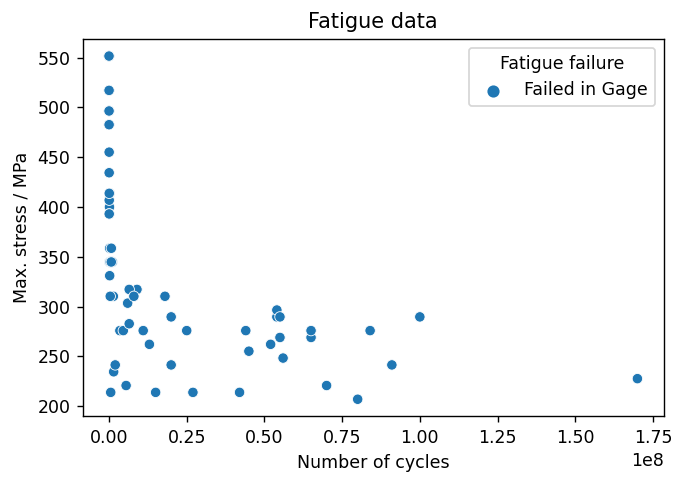

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams['figure.dpi'] = 125

fig, ax = plt.subplots()
ax = sns.scatterplot(data=rs_df, y='Maximum stress', x='Cyclic life', hue='Fatigue failure', ax=ax)

plt.title("Fatigue data")
plt.xlabel("Number of cycles")
plt.ylabel("Max. stress / " + test_data_table.attributes['Maximum stress'].unit)
plt.show()

Add the fitted curve and the minimum curve to the plot, and set the x-axis scale to logarithmic.

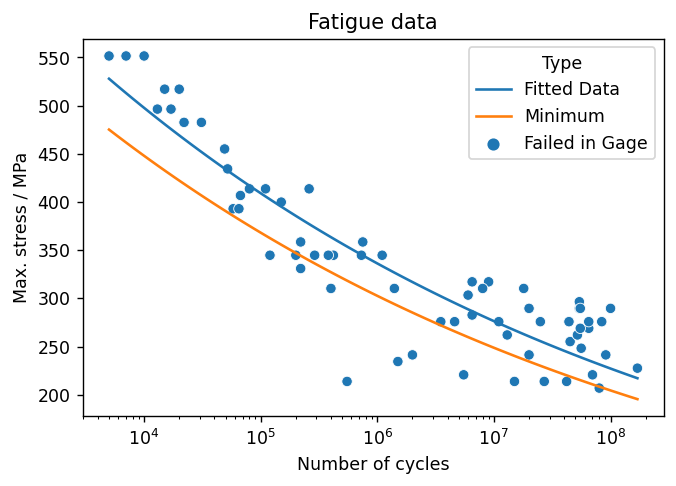

In [6]:
sns.lineplot(data=fitted_df, x='Cyclic life', y='Maximum stress', hue='Type', ax=ax)
ax.set(xscale='log')

fig

## Import the fitted data to Granta MI

Replace the data in the original record's functional attribute *Maximum Stress v Cycles (Equivalent Stress)* with the fitted data. Use `Session.update()` to push the changes to Granta MI.

In [7]:
fit = r.attributes['Maximum Stress v Cycles (Equivalent Stress)']
fit.clear()
fit.unit = test_data_table.attributes['Maximum stress'].unit

for _, row in fitted_df.iterrows():
    fit.add_point({'y': row['Maximum stress'],
                   'Number of Cycles': row['Cyclic life'],
                   'Data Type': row['Type'],
                   'Stress Ratio': r_ratio})
for _, row in rs_df.iterrows():
    fit.add_point({'y': row['Maximum stress'],
                   'Number of Cycles': row['Cyclic life'],
                   'Data Type': 'Test Data',
                   'Stress Ratio': r_ratio})

fit.series_linestyles[3] = 'Markers'

r.attributes["Equivalent Stress, A1"].points = [A1]
r.attributes["Equivalent Stress, A2"].points = [A2]
r.attributes["Statistical Analysis Status"].value = ["Complete"]
r.set_attributes([r.attributes["Equivalent Stress, A1"], r.attributes["Equivalent Stress, A2"],
                  r.attributes["Statistical Analysis Status"], fit])
fit.data
s.update([r])
print('Updated attributes in ' + str(r.name) + '.')

Updated attributes in 7075 T6, R=0, T=430F.


## Create traceability links

Add a record link group, and use `Session.update_links()` to push the changes to Granta MI.

In [8]:
rec_link_group = r.links['Fatigue Test Data']
for rsi in records:
    rec_link_group.add(rsi)
r.set_links('Fatigue Test Data',rec_link_group)
s.update_links([r])
print('Updated links in ' + str(r.name) + '.')

Updated links in 7075 T6, R=0, T=430F.
